# Tutorial 2: STARmap data (mPFC)

Here, we applied GraphPCA to the high-resolution image-based ST data, specifically the mouse medial prefrontal cortex (mPFC) data generated by STARmap. We downloaded annotations in both domain- and cell-levels of each cell from [the original study](https://www.science.org/doi/10.1126/science.aat5691) as ground truth to evaluate clustering performance

## Load packages

In [1]:
import GraphPCA as sg
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import squidpy as sq
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances as pair
from sklearn.metrics import adjusted_rand_score as ari_score

## Setting parameters

In [2]:
data_path = "../../data/STARmap/"
save_path = "../../results/STARmap/"
PCA_components = 50

STARmap_expr = pd.read_csv(data_path + "STARmap_expr.csv",index_col=0).T
STARmap_loc = pd.read_csv(data_path + "STARmap_loc.csv",index_col=0)
groundTruth = pd.read_csv(data_path + "STARmap_groundtruth.csv",index_col=0)["z"].astype("category")
adata = ad.AnnData(STARmap_expr)
adata.obs = STARmap_loc.copy()
adata.uns["spatial"] = np.array(STARmap_loc)

adata.obs["groundtruth"] =np.array(groundTruth)-1
adata.obs["groundtruth"] = adata.obs["groundtruth"].astype(int).astype("category")
adata

AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'x', 'y', 'groundtruth'
    uns: 'spatial'

## Preprocessing

Before performing GraphPCA, we assumed that the gene expression counts have already been preprocessed with analytic Pearson residuals proposed by [Lause et al.](https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html) and further scaled for each gene to have 0 mean and unit standard deviation. 

In [3]:
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=20)
sc.experimental.pp.normalize_pearson_residuals(adata)
sc.pp.scale(adata)
adata

AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'x', 'y', 'groundtruth'
    var: 'n_cells', 'mean', 'std'
    uns: 'spatial', 'pearson_residuals_normalization'

## Perform GraphPCA

In [4]:
x_array=adata.obs["x"].tolist()
y_array=adata.obs["y"].tolist()
location=np.array([x_array, y_array]).T.astype(np.float32)
Z,W = sg.Run_GPCA(adata, location=location, n_components = 50, method = "knn",  n_neighbors = 7, _lambda =0.5,
                save_reconstruction=True)
adata.obsm["GraphPCA"] = Z
print(Z.shape)

(1049, 50)


## Clustering

In [5]:
estimator = KMeans(n_clusters=4)
res = estimator.fit(Z[:,:])
lable_pred=res.labels_
adata.obs["GPCA_pred"]= lable_pred
adata.obs["GPCA_pred"] = adata.obs["GPCA_pred"].astype('category')
refined_pred=sg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["GPCA_pred"].tolist(), dis= pair(location),
                       shape="generic",neighbor_num=7)
adata.obs["GPCA_pred"]= refined_pred
adata.obs["GPCA_pred"] = adata.obs["GPCA_pred"].astype('category')
print(ari_score(adata.obs.GPCA_pred,adata.obs.groundtruth))

0.8682823215084668


## Visualization

In [6]:
adata.obs['GPCA_pred'] = pd.Series(sg.match_cluster_labels(adata.obs['groundtruth'], adata.obs['GPCA_pred'].values),
                                         index=adata.obs.index, dtype='category')

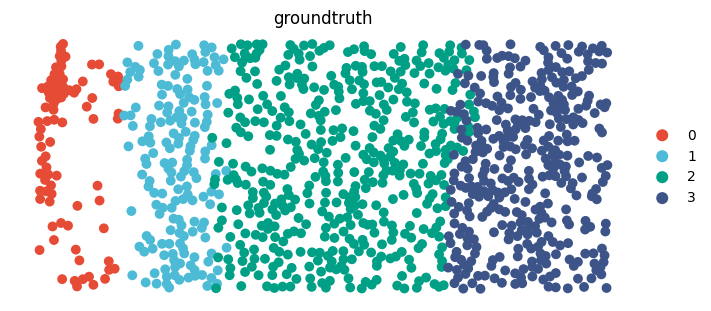

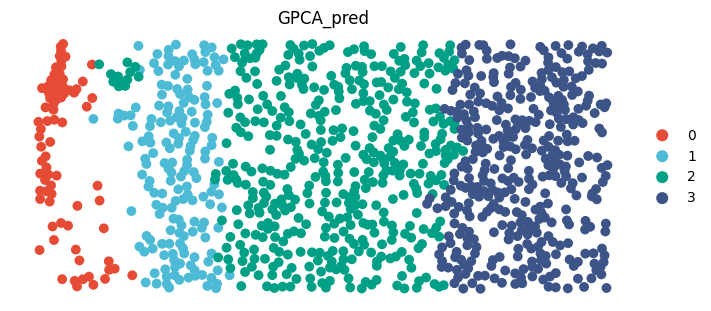

In [7]:
color_list = ["#E64B35FF","#4DBBD5FF","#00A087FF","#3C5488FF"] 
sg.make_scatterplot(adata,column_name="groundtruth", 
                 color_list=color_list,
                 coord_x="x",coord_y="y",
                 use_title=True,
                 only_point=True, 
                 size=200,
                 figsize_width=7, 
                 figsize_height=3 )

sg.make_scatterplot(adata,column_name="GPCA_pred", 
                 color_list=color_list,
                 coord_x="x",coord_y="y",
                 use_title=True,
                 only_point=True, 
                 size=200,
                 figsize_width=7, 
                 figsize_height=3 )

## Coexpression module

In [8]:
GPCA_pcs = pd.DataFrame(adata.obsm["GraphPCA"])
GPCA_pcs.index = adata.to_df().index
GPCA_pcs.columns = [ "PC_" + str(i) for i in np.arange(GPCA_pcs.shape[1]) ]

In [9]:
adata.obs = pd.concat([adata.obs,GPCA_pcs],axis=1)

In [10]:
sc.set_figure_params( color_map = 'viridis',figsize=(5,5))

In [11]:
adata.obsm["spatial"] = adata.uns["spatial"].copy()
del adata.uns["spatial"]

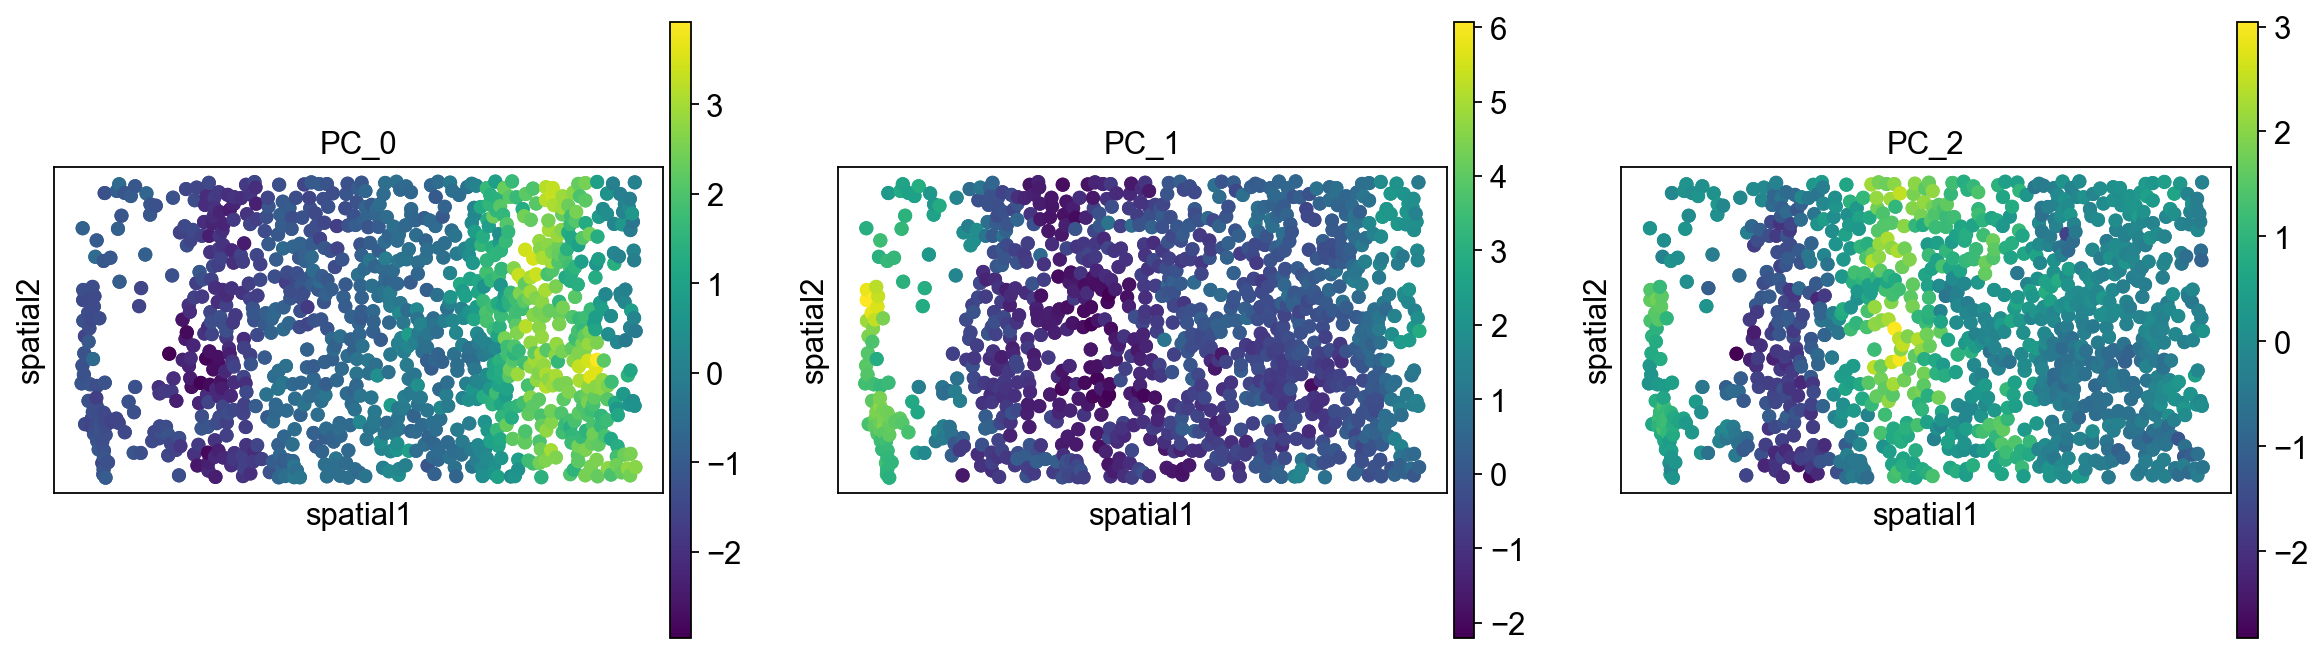

In [12]:
sq.pl.spatial_scatter(adata,color=["PC_0","PC_1","PC_2"],shape=None)

In [13]:
GPCA_w = pd.DataFrame(W)
GPCA_w.index = adata.to_df().columns
GPCA_w.columns = [ "PC_" + str(i) for i in np.arange(GPCA_w.shape[1]) ]

In [14]:
top_3_rows = {}
for column in GPCA_w.columns:
    top_3_rows[column] = GPCA_w.abs().nlargest(3, column).index.tolist()

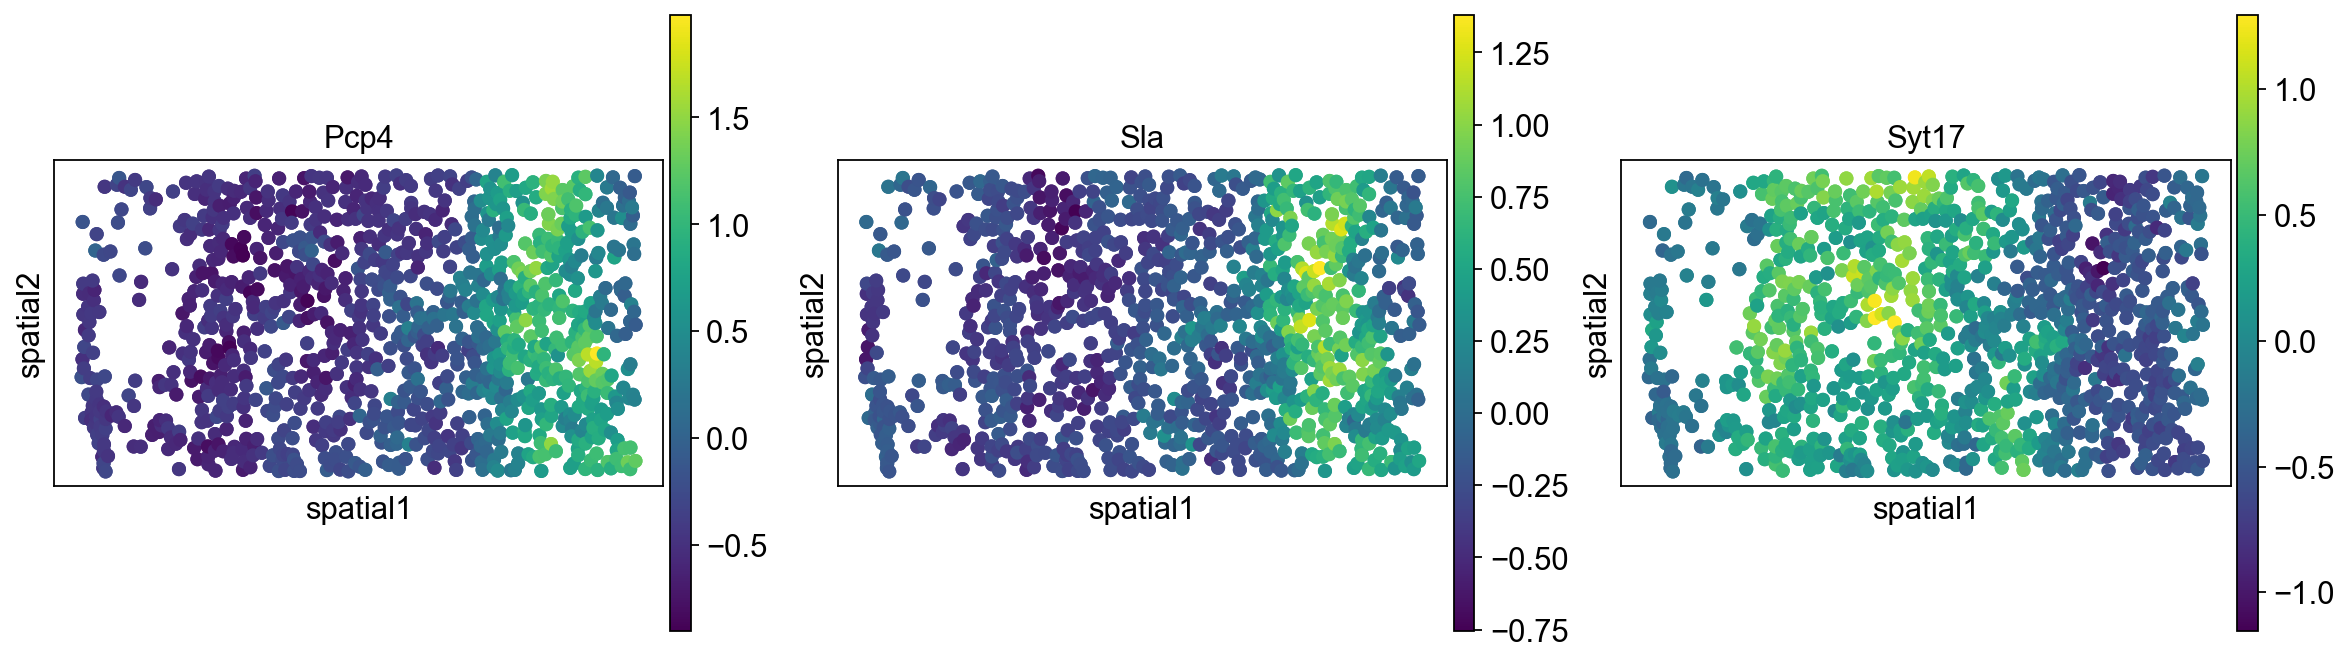

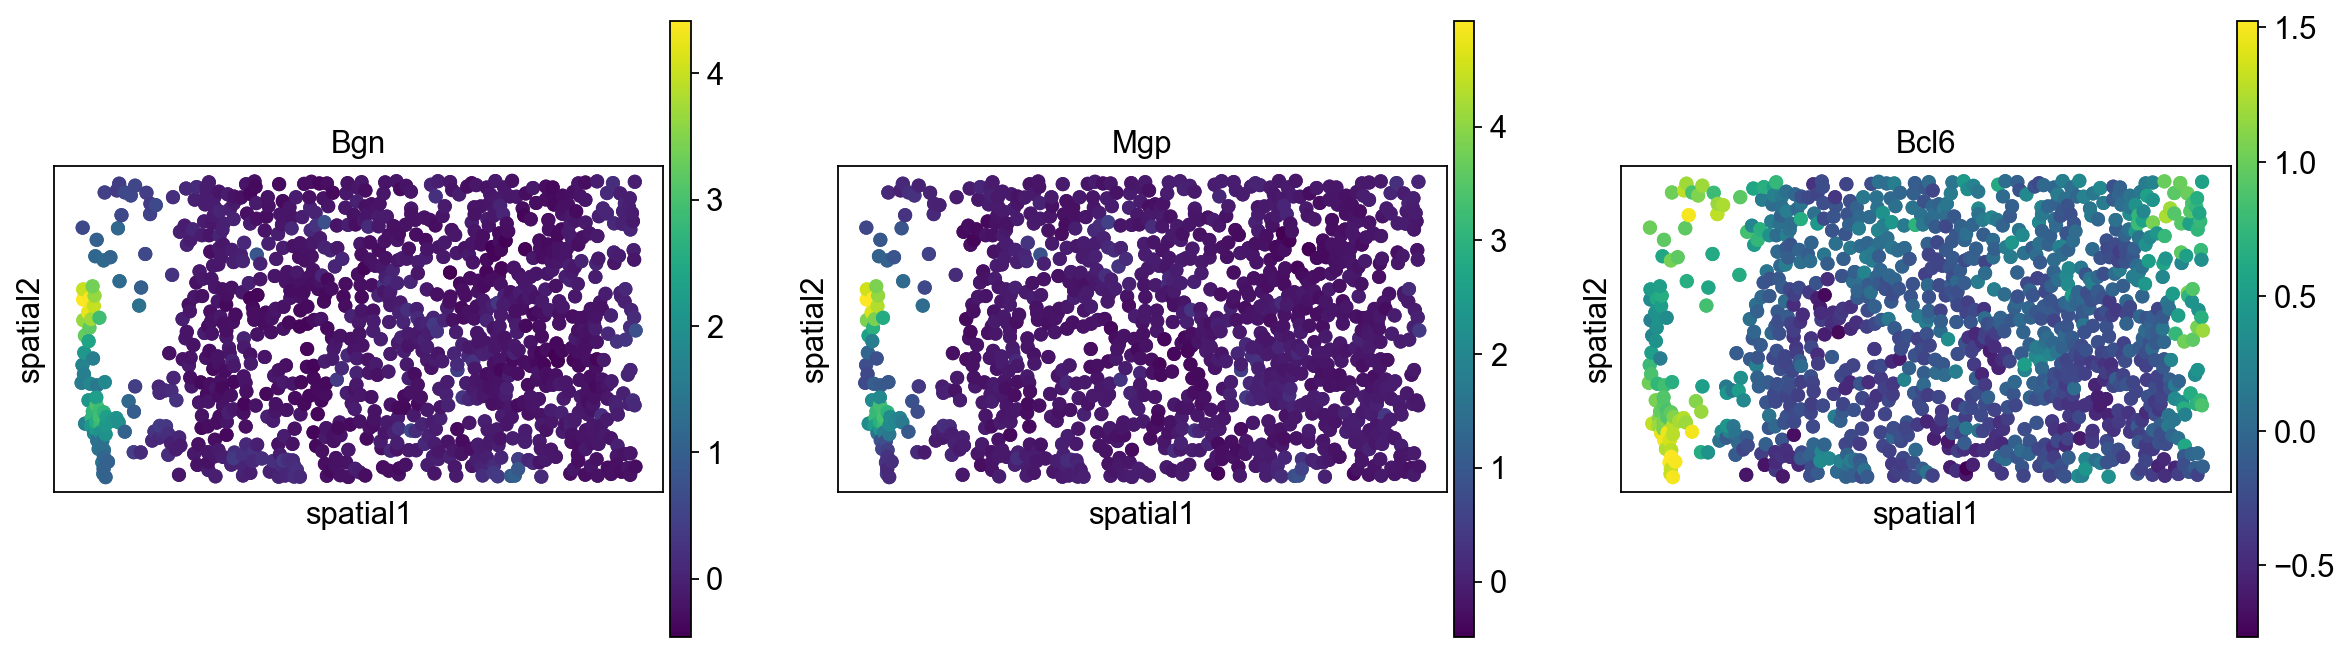

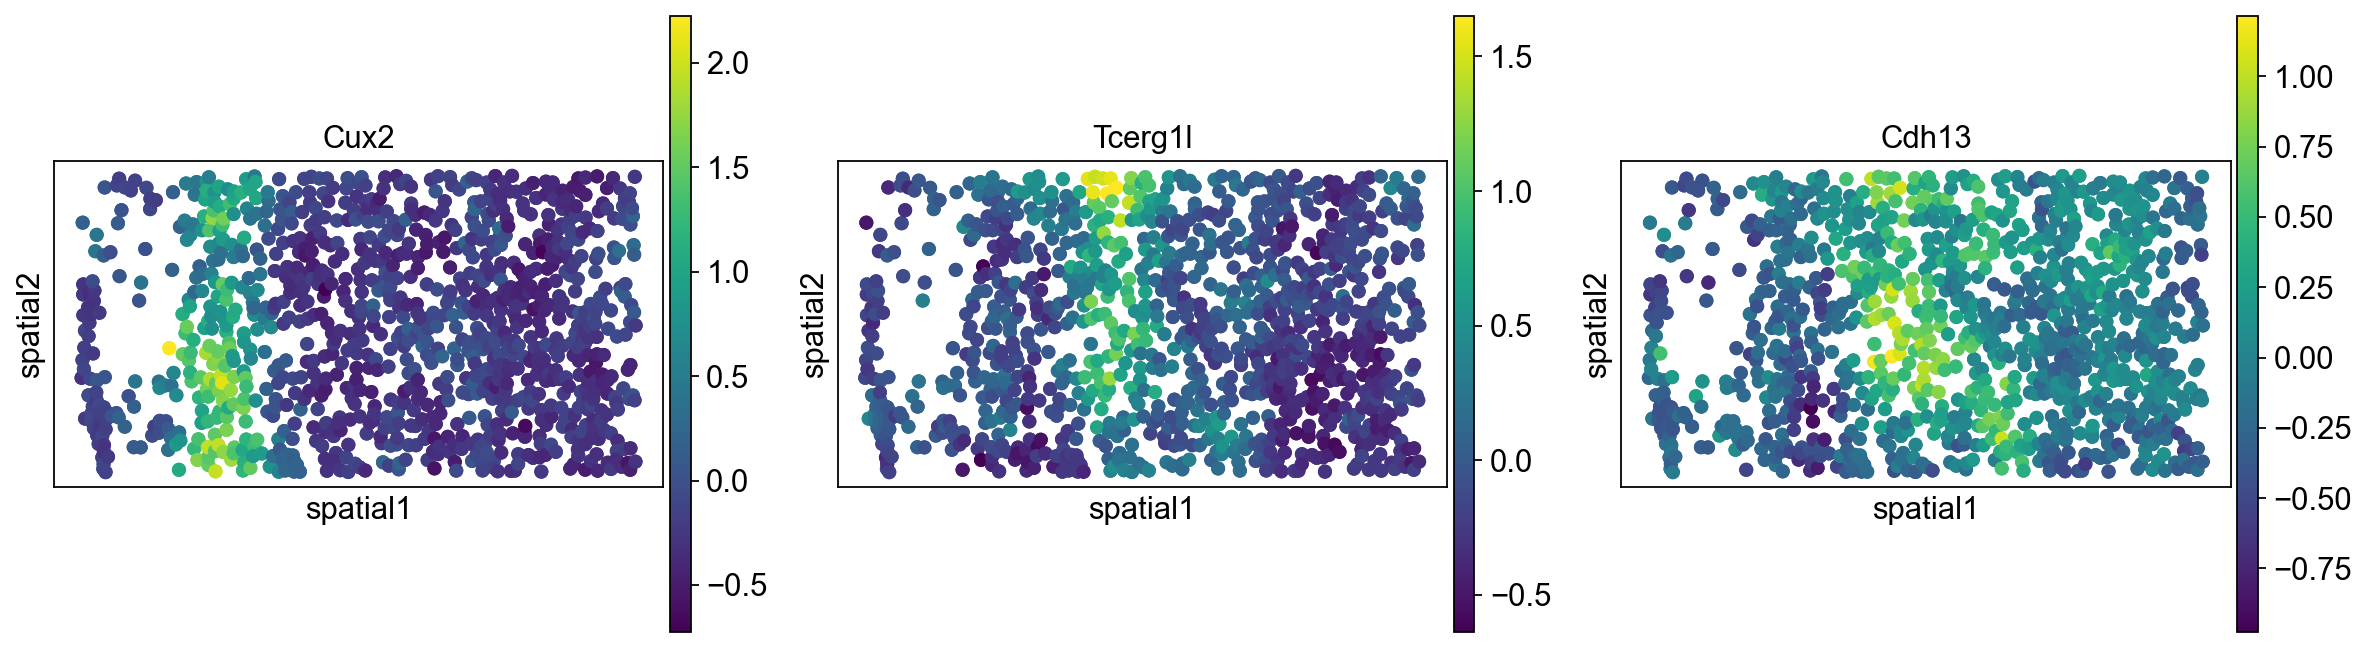

In [15]:
sq.pl.spatial_scatter(adata,color=top_3_rows["PC_0"],shape=None,layer="GraphPCA_ReX")
sq.pl.spatial_scatter(adata,color=top_3_rows["PC_1"],shape=None,layer="GraphPCA_ReX")
sq.pl.spatial_scatter(adata,color=top_3_rows["PC_2"],shape=None,layer="GraphPCA_ReX")